## Using LSTM to predict Bit Coin Currency

Edited by Una
Date: 2021-07-14


#### Install packages:

> pip3 install -r requirement.txt

requirement.txt

numpy
pandas
matplotlib
sklearn
torch
seaborn

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import math, time
import torch.nn as nn
from sklearn.metrics import mean_squared_error,mean_absolute_error

## 1. Loadin data and data preprocessing

normalization for close price : 

[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [185]:
### Loadin the csv data
dataset = pd.read_csv("BTC.csv", header=None, names = ["date","close","vol"], index_col=0, parse_dates=True)

In [186]:
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2830 entries, 2014-01-01 to 2021-09-30
Data columns (total 2 columns):
close    2830 non-null float64
vol      2830 non-null float64
dtypes: float64(2)
memory usage: 66.3 KB
None


,close,vol
date,,
2014-01-01,771.40,22489400.0
2014-01-02,802.39,38489500.0
2014-01-03,818.72,37810100.0
2014-01-04,859.51,38005000.0
2014-01-05,933.53,72898496.0


In [187]:
## Close price normalization to 0-1
scaler = MinMaxScaler()# default feature_range=(0,1)
dataset_scaled = scaler.fit_transform(dataset.close.values.reshape(-1,1))

use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

In [188]:
## Convert the normalized close price to a vector of lookback-dimension with lookback history data
def split_data(stock, lookback):
    data = []
    for index in range(len(stock) - lookback):
        data.append(stock[index: index + lookback])

    data = np.array(data)
    train_val_slip = int(0.8* data.shape[0])


    x_train = data[:train_val_slip,:-1,:]
    y_train = data[:train_val_slip,-1,:]

    x_test = data[train_val_slip:,:-1]
    y_test = data[train_val_slip:,-1,:]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = split_data(dataset_scaled, lookback)
x_train_torch = torch.from_numpy(x_train).type(torch.Tensor)
x_test_torch = torch.from_numpy(x_test).type(torch.Tensor)
y_train_torch = torch.from_numpy(y_train).type(torch.Tensor)
y_test_torch = torch.from_numpy(y_test).type(torch.Tensor)

## 2. Creat NN model

In [189]:
# 构造模型
class LSTM(nn.Module):
    # __init__定义网络中的参数和模型框架，初始化传入输入、隐藏层、输出三个参数
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()#继承__init__功能
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)#隐藏层输出
        self.fc = nn.Linear(hidden_dim, output_dim)#输出层输出

    #forward定义传输数据的连接，即网络或者模型中的走向，传入计算值的函数，正向传播输入值，神经网络分析出输出值
    def forward(self, x):
        # 用零初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        # 初始化细胞单元状态
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        #detach分离，截断时间反向传播BPTT
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # out[:, -1, :]只需要最后一步的隐藏状态
        out = self.fc(out[:, -1, :])
        return out


In [190]:
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

## 3. Train the model

In [191]:
num_epochs = 1000
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [192]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train_torch.to(device))
    loss = criterion(y_train_pred, y_train_torch.to(device))
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.008777867071330547
Epoch  1 MSE:  0.005713141988962889
Epoch  2 MSE:  0.004151537083089352
Epoch  3 MSE:  0.0039005232974886894
Epoch  4 MSE:  0.004459841642528772
Epoch  5 MSE:  0.004908687435090542
Epoch  6 MSE:  0.00488832825794816
Epoch  7 MSE:  0.0045780916698277
Epoch  8 MSE:  0.004218620713800192
Epoch  9 MSE:  0.003955047577619553
Epoch  10 MSE:  0.0038338652811944485
Epoch  11 MSE:  0.003836322808638215
Epoch  12 MSE:  0.003912212327122688
Epoch  13 MSE:  0.004005979280918837
Epoch  14 MSE:  0.004075105767697096
Epoch  15 MSE:  0.004098571836948395
Epoch  16 MSE:  0.004075412172824144
Epoch  17 MSE:  0.0040181842632591724
Epoch  18 MSE:  0.003945596050471067
Epoch  19 MSE:  0.003876319620758295
Epoch  20 MSE:  0.003824623767286539
Epoch  21 MSE:  0.0037978775799274445
Epoch  22 MSE:  0.003795880824327469
Epoch  23 MSE:  0.0038119482342153788
Epoch  24 MSE:  0.0038355165161192417
Epoch  25 MSE:  0.0038556326180696487
Epoch  26 MSE:  0.003864262020215392
Epoch  

In [193]:
y_train_model = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train_original = scaler.inverse_transform(y_train)

#####Visulization
# plt.plot(y_train_original, color = 'red', label = 'BTC True Price')
# plt.plot(y_train_model, color = 'blue', label = 'BTC predicted Price')
# plt.title('BTC Price')
# plt.legend(['Training Prediction (LSTM)','Data'])
# plt.show()

## 4. Predict on the testset

In [194]:
y_test_pred = model(x_test_torch.to(device))

y_test_model = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test_original = scaler.inverse_transform(y_test)

In [195]:
# 计算实际损失
trainRMSE = math.sqrt(mean_squared_error(y_train_original, y_train_model))
trainMAE = mean_absolute_error(y_train_original, y_train_model)
trainMAPE = np.mean(np.abs((y_train_model - y_train_original) / y_train_original)) * 100
print('Train Score: %.4f RMSE, %.4f MAE, %.4f MAPE' % (trainRMSE,trainMAE,trainMAPE))
testRMSE = math.sqrt(mean_squared_error(y_test_original, y_test_model))
testMAE = mean_absolute_error(y_test_original, y_test_model)
testMAPE = np.mean(np.abs((y_test_model - y_test_original) / y_test_original)) * 100
print('Test Score: %.4f RMSE, %.4f MAE, %.4f MAPE' % (testRMSE,testMAE,testMAPE))

Train Score: 394.6599 RMSE, 186.5485 MAE, 6.7740 MAPE
Test Score: 7087.7765 RMSE, 4816.1019 MAE, 11.9420 MAPE


## 5. Visualization

In [196]:
# #####Visulization
# plt.plot(y_test_original, color = 'red', label = 'BTC True Price')
# plt.plot(y_test_model, color = 'blue', label = 'BTC predicted Price')
# plt.title('BTC Price')
# plt.legend(['Training Prediction (LSTM)','Data'])
# plt.show()

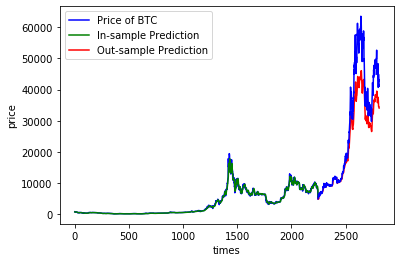

In [197]:
N_original, N_test = len(y_train_original),len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original
## Show all curve
plt.plot(y_train_original, color = 'blue', label = 'Price of BTC')
plt.plot(y_train_model, color = 'green', label = 'In-sample Prediction')
plt.xlabel('times')
plt.ylabel('price')
plt.plot(index_test, y_test_model, color = 'red', label = 'Out-sample Prediction')
plt.plot(index_test, y_test_original, color = 'blue', label = 'Price of BTC')
# plt.plot(index_test, y_test_model, color = 'red', label = 'Out-sample Prediction')
plt.legend(['Price of BTC','In-sample Prediction','Out-sample Prediction'])
plt.savefig("TestLSTM20-3.png", dpi=500)
plt.show()
df_LSTM_predict_train_20_3 = pd.DataFrame({'y_test_original_20_3':y_test_original.flatten(),'y_test_model_20_3':y_test_model.flatten()})
df_LSTM_predict_train_20_3.to_csv(r"./data/df_LSTM_predict_train_20_3.csv",sep=',')